[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/041_attention/attention.ipynb)

# Mecanismos de Atención

En el [post](https://sensioai.com/blog/040_encoder_decoder) anterior aprendimos a implementar una arquitectura de red neuronal conocida como `seq2seq`, que utiliza dos redes neuronales (el `encoder` y el `decoder`) para poder trabajar con secuencias de longitud arbitraria tanto a sus entradas como en las salidas. Este modelo nos permite llevar a cabo tareas tales como la traducción de texto entre dos idiomas, resumir un texto, responder preguntas, etc.

![](https://pytorch.org/tutorials/_images/seq2seq.png)

Si bien este modelo nos dio buenos resultados, podemos mejorarlo. Si prestamos atención a la arquitectura que desarrollamos, el `decoder` (encargado de generar la secuencia de salida) es inicializado con el último estado oculto del `encoder`, el cual tiene la responsabilidad de codificar el significado de toda la frase original. Esto puede ser complicado, sobre todo al trabajar con secuencias muy largas, y para solventar este problema podemos utilizar un mecanismo de `atención` que no solo reciba el último estado oculto si no también tenga acceso a todas las salidas del `encoder` de manera que el `decoder` sea capaz de "focalizar su atención" en aquellas partes más importantes. Por ejemplo, para traducir la primera palabra es lógico pensar que lo más importante será la primera palabra y sus adyacentes en la frase original, pero usar el último estado oculto del `encoder` puede no ser suficiente para mantener estas relaciones a largo plazo. Permitir al `decoder` acceder a esta información puede resultar en mejores prestaciones.

> 💡 En la práctica, los mecanismos de atención dan muy buenos resultados en tareas que envuelvan datos secuenciales (como aplicaciones de lenguaje). De hecho, los mejores modelos a día de hoy para tareas de `NLP` no están basados en redes recurrentes sino en arquitecturas que únicamente implementan mecanismos de atención en varias capas. Estas redes neuronales son conocidas como `Transformers`.

## El *dataset*

Vamos a resolver exactamente el mismo caso que en el post anterior, así que todo lo que hace referencia al procesado de datos lo dejaremos igual.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def read_file(file, reverse=False):
    # Read the file and split into lines
    lines = open(file, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    return pairs

In [3]:
pairs = read_file('/content/drive/MyDrive/SIS421/EXAMENFINAL/dialogos.txt')
#pairs = read_file('spa.txt')

In [4]:
import random

#random.choice(pairs)
print(pairs[0] )

# Mostrar el primer par de preguntas y respuestas
first_pair = pairs[0]
pregunt = first_pair[0]
respuest = first_pair[1]

print("Pregunta:", pregunt)
print("Respuesta:", respuest)

['hi how are you doing ?', 'i m fine . how about yourself ?']
Pregunta: hi how are you doing ?
Respuesta: i m fine . how about yourself ?


In [5]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

class Lang:
    def __init__(self, language):
        self.language = language
        self.word2id = {"SOS": 0, "EOS": 1, "PAD": 2}
        self.word2count = {}
        self.id2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3  # Count SOS, EOS and PAD

    def addQuestion(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2id:
            self.word2id[word] = self.n_words
            self.word2count[word] = 1
            self.id2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def idsFromQuestion(self, sentence):
        return [self.word2id[word] for word in sentence.split(' ')]

    def questionFromIds(self, index):
        return [self.id2word[ix] for ix in index]

Para poder aplicar la capa de `attention` necesitamos que nuestras frases tengan una longitud máxima definida.

In [6]:
MAX_LENGTH = 20
def filterPairs(pairs, filters, lang=0):
    return pairs
def trimPairs(pairs):
    return [p for p in pairs if len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH]

In [7]:
def prepareData(file, filters=None, reverse=False):

    pairs = read_file(file, reverse)
    print(f"Tenemos {len(pairs)} pares de frases")

    pairs = trimPairs(pairs)
    print(f"Tenemos {len(pairs)} pares de frases con longitud menor de {MAX_LENGTH}")

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        question_lang = Lang('answer')
        answer_lang = Lang('question')
    else:
        question_lang = Lang('question')
        answer_lang = Lang('answer')

    for pair in pairs:
        question_lang.addQuestion(pair[0])
        answer_lang.addQuestion(pair[1])

        # add <eos> token
        pair[0] += " EOS"
        pair[1] += " EOS"

    print("Longitud vocabularios:")
    print(question_lang.language, question_lang.n_words)
    print(answer_lang.language, answer_lang.n_words)

    return question_lang, answer_lang, pairs

question_lang, answer_lang, pairs = prepareData('/content/drive/MyDrive/SIS421/EXAMENFINAL/dialogos.txt')

# descomentar para usar el dataset filtrado
#question_lang, answer_lang, pairs = prepareData('spa.txt', filters=eng_prefixes)

random.choice(pairs)

Tenemos 3725 pares de frases
Tenemos 3712 pares de frases con longitud menor de 20
Longitud vocabularios:
question 2285
answer 2339


['tomorrow i m going to buy an electric sharpener . EOS',
 'get one with the rubber suction cups on the bottom . EOS']

In [8]:
answer_lang.idsFromQuestion('what school do you go to .')

[24, 26, 29, 20, 30, 31, 6]

In [9]:
answer_lang.questionFromIds([3, 1028, 647, 5])

['i', 'wonder', 'poodle', 'fine']

En el `Dataset` nos aseguraremos de añadir el *padding* necesario para que todas las frases tengan la misma longitud, lo cual no hace necesario utilizar la función `collate` que implementamos en el post anterior.

In [10]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
    def __init__(self, question_lang, answer_lang, pairs, max_length):
        self.question_lang = question_lang
        self.answer_lang = answer_lang
        self.pairs = pairs
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, ix):
        inputs = torch.tensor(self.question_lang.idsFromQuestion(self.pairs[ix][0]), device=device, dtype=torch.long)
        outputs = torch.tensor(self.answer_lang.idsFromQuestion(self.pairs[ix][1]), device=device, dtype=torch.long)
        # metemos padding a todas las frases hast a la longitud máxima
        return torch.nn.functional.pad(inputs, (0, self.max_length - len(inputs)), 'constant', self.question_lang.word2id['PAD']), \
            torch.nn.functional.pad(outputs, (0, self.max_length - len(outputs)), 'constant', self.answer_lang.word2id['PAD'])

# separamos datos en train-test
train_size = len(pairs) * 80 // 100
train = pairs[:train_size]
test = pairs[train_size:]

dataset = {
    'train': Dataset(question_lang, answer_lang, train, max_length=MAX_LENGTH),
    'test': Dataset(question_lang, answer_lang, test, max_length=MAX_LENGTH)
}

len(dataset['train']), len(dataset['test'])

(2969, 743)

In [11]:
question_sentence, answer_sentence = dataset['train'][0]

question_sentence, answer_sentence

(tensor([3, 4, 5, 6, 7, 8, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([ 3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2]))

In [12]:
question_lang.questionFromIds(question_sentence.tolist()), answer_lang.questionFromIds(question_sentence.tolist())

(['hi',
  'how',
  'are',
  'you',
  'doing',
  '?',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['i',
  'm',
  'fine',
  '.',
  'how',
  'about',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'])

In [13]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=128, shuffle=False),
}

inputs, outputs = next(iter(dataloader['train']))
inputs.shape, outputs.shape
print(inputs)

tensor([[  9,  10, 788,  ...,   2,   2,   2],
        [214, 106,  34,  ...,   2,   2,   2],
        [369, 123, 244,  ...,   2,   2,   2],
        ...,
        [255,   6, 167,  ...,   2,   2,   2],
        [907, 610, 906,  ...,   2,   2,   2],
        [256, 241,  39,  ...,   2,   2,   2]])


## El modelo

En lo que se refiere al `encoder`, seguimos usando exactamente la misma arquitectura. La única diferencia es que, además del último estado oculto, necesitaremos todas sus salidas para que el `decoder` pueda usarlas.

In [24]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=128, hidden_size=128, n_layers=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)

    def forward(self, input_sentences):
        embedded = self.embedding(input_sentences)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden


In [25]:
encoder = Encoder(input_size=question_lang.n_words)
encoder_outputs, encoder_hidden = encoder(torch.randint(0, question_lang.n_words, (64, 20)))

# [batch size, seq len, hidden size]
encoder_outputs.shape

torch.Size([64, 20, 128])

In [26]:
# [num layers, batch size, hidden size]
encoder_hidden.shape

torch.Size([5, 64, 128])

### El *decoder* con *attention*

Vamos a ver un ejemplo de implementación de una capa de atención para nuestro `decoder`. En primer lugar tendremos una capa lineal que recibirá como entradas los `embeddings` y el estado oculto anterior (concatenados). Esta capa lineal nos dará a la salida tantos valores como elementos tengamos en nuestras secuencias de entrada (recuerda que las hemos forzado a tener una longitud determinada). Después, aplicaremos una función `softmax` sobre estos valores obteniendo así una distribución de probabilidad que, seguidamente, multiplicaremos por los *outputs* del encoder (que también tienen la misma longitud). En esta función de probabilidad, cada elemento tiene un valor entre 0 y 1. Así pues, esta operación dará más importancia a aquellos *outputs* del `encoder` más importantes mientras que al resto les asignará unos valores cercanos a 0. A continuación, concatenaremos estos valores con los `embeddings`, de nuevo, y se lo daremos a una nueva capa lineal que combinará estos `embeddings` con los *outputs* del `encoder` re-escalados para obtener así los *inputs* finales de la capa recurrente.

En resumen, usaremos las entradas y estado oculto del `decoder` para encontrar unos pesos que re-escalarán las salidas del `encoder`, los cuales combinaremos de nuevo con las entradas del `decoder` para obtener las representaciones finales de nuestras frases que alimentan la capa recurrente.

![](https://i.imgur.com/1152PYf.png)

In [27]:
class DialogDecoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size=128, hidden_size=128, n_layers=5, max_length=MAX_LENGTH):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.gru = torch.nn.GRU(embedding_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.out = torch.nn.Linear(hidden_size, input_size)

        # attention
        self.attn = torch.nn.Linear(hidden_size + embedding_size, max_length)
        self.attn_combine = torch.nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, input_dialogue, hidden, encoder_outputs):
        # Obtenemos los embeddings de los turnos de diálogo
        embedded = self.embedding(input_dialogue)

        # Calculamos los pesos de atención entre los turnos de diálogo y el estado oculto anterior
        attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
        uno=attn_weights.unsqueeze(1)

        # Realizamos la atención entre los turnos de diálogo y el encoder_outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        # Concatenamos los embeddings con la atención aplicada
        output = torch.cat((embedded.squeeze(1), attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output)
        output = torch.nn.functional.relu(output)

        # Aplicamos la capa GRU con la entrada ajustada
        output, hidden = self.gru(output.unsqueeze(1), hidden)

        # Generamos la salida final
        output = self.out(output.squeeze(1))

        return output, hidden, attn_weights



In [28]:
decoder = DialogDecoder(input_size=answer_lang.n_words)
decoder_output, decoder_hidden, attn_weights = decoder(torch.randint(0, answer_lang.n_words, (64,1)), encoder_hidden, encoder_outputs)

# [batch size, vocab size]
decoder_output.shape

<ipython-input-27-c73859c09972>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


torch.Size([64, 2339])

In [29]:
# [num layers, batch size, hidden size]
decoder_hidden.shape

torch.Size([5, 64, 128])

In [30]:
# [batch size, max_length]
attn_weights.shape

torch.Size([64, 20])

## Entrenamiento

Vamos a implementar el bucle de entrenamiento. En primer lugar, al tener ahora dos redes neuronales, necesitaremos dos optimizadores (uno para el `encoder` y otro para el `decoder`). Al `encoder` le pasaremos la frase en el idioma original, y obtendremos el estado oculto final. Este estado oculto lo usaremos para inicializar el `decoder` que, junto al token `<sos>`, generará la primera palabra de la frase traducida. Repetiremos el proceso, utilizando como entrada la anterior salida del decoder, hasta obtener el token `<eos>`.

In [31]:
from tqdm import tqdm
import numpy as np

def fit(encoder, decoder, dataloader, epochs=10):
    encoder.to(device)
    decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    #criterion = torch.nn.functional.cross_entropy()
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_loss = []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            input_sentences, output_sentences = batch
            bs = input_sentences.shape[0]
            loss = 0
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            # obtenemos el último estado oculto del encoder
            encoder_outputs, hidden = encoder(input_sentences)
            # calculamos las salidas del decoder de manera recurrente
            decoder_input = torch.tensor([[answer_lang.word2id['SOS']] for b in range(bs)], device=device)
            for i in range(output_sentences.shape[1]):
                output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                loss += criterion(output, output_sentences[:, i].view(bs))
                # el siguiente input será la palabra predicha
                decoder_input = torch.argmax(output, axis=1).view(bs, 1)
            # optimización
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

        val_loss = []
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            bar = tqdm(dataloader['test'])
            for batch in bar:
                input_sentences, output_sentences = batch
                bs = input_sentences.shape[0]
                loss = 0
                # obtenemos el último estado oculto del encoder
                encoder_outputs, hidden = encoder(input_sentences)
                # calculamos las salidas del decoder de manera recurrente
                decoder_input = torch.tensor([[answer_lang.word2id['SOS']] for b in range(bs)], device=device)
                for i in range(output_sentences.shape[1]):
                    output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
                    loss += criterion(output, output_sentences[:, i].view(bs))
                    # el siguiente input será la palabra predicha
                    decoder_input = torch.argmax(output, axis=1).view(bs, 1)
                val_loss.append(loss.item())
                bar.set_description(f"Epoch {epoch}/{epochs} val_loss {np.mean(val_loss):.5f}")

In [32]:
fit(encoder, decoder, dataloader, epochs=100)

  0%|          | 0/47 [00:00<?, ?it/s]<ipython-input-27-c73859c09972>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))
Epoch 100/100 val_loss 90.55884: 100%|██████████| 6/6 [00:01<00:00,  4.52it/s]


## Generando traducciones

Una vez tenemos nuestro modelo entrenado, podemos utilizarlo para traducir frases del inglés al castellano de la siguiente manera.

In [33]:
input_sentence, output_sentence = dataset['test'][0]
question_lang.questionFromIds(input_sentence.tolist()), answer_lang.questionFromIds(output_sentence.tolist())

(['and',
  'people',
  'showed',
  'up',
  '.',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['so',
  'many',
  'people',
  'are',
  'out',
  'of',
  'work',
  '.',
  'EOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'])

In [34]:
def predict(input_sentence):
    # obtenemos el último estado oculto del encoder
    encoder_outputs, hidden = encoder(input_sentence.unsqueeze(0))
    # calculamos las salidas del decoder de manera recurrente
    decoder_input = torch.tensor([[answer_lang.word2id['SOS']]], device=device)
    # iteramos hasta que el decoder nos de el token <eos>
    outputs = []
    decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)
    i = 0
    while True:
        output, hidden, attn_weights = decoder(decoder_input, hidden, encoder_outputs)
        decoder_attentions[i] = attn_weights.data
        i += 1
        decoder_input = torch.argmax(output, axis=1).view(1, 1)
        outputs.append(decoder_input.cpu().item())
        if decoder_input.item() == answer_lang.word2id['EOS']:
            break
    return answer_lang.questionFromIds(outputs), decoder_attentions

In [35]:
output_words, attn = predict(input_sentence)
output_words

<ipython-input-27-c73859c09972>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded.squeeze(1), hidden[0]), dim=1)))


['what', 'are', 'that', '?', 'EOS']

## Visualización de atención

Una de las ventajas que nos da la capa de atención es que nos permite visualizar en qué partes de los inputs se fija el modelo para generar cada una de las palabras en el output, dando un grado de explicabilidad a nuestro modelo (una propiedad siempre deseada en nuestro modelos de `Machine Learning`).

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    lim1, lim2 = input_sentence.index('EOS')+1, output_words.index('EOS')+1
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions[:lim2, :lim1].numpy(), cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
    ax.set_yticklabels([' '] + output_words)
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

<ipython-input-36-c3618fc79f44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' '] + input_sentence[:lim1], rotation=90)
<ipython-input-36-c3618fc79f44>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '] + output_words)


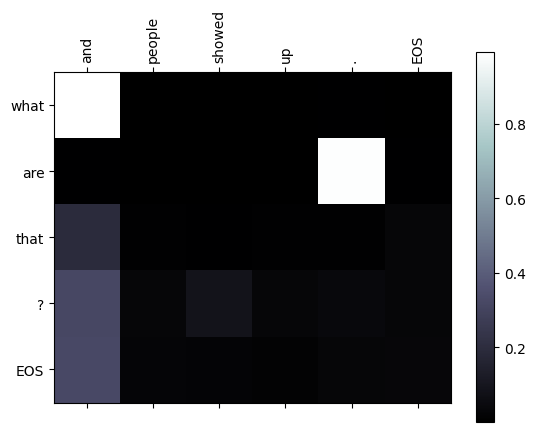

In [37]:
showAttention(question_lang.questionFromIds(input_sentence.tolist()), output_words, attn)

TRANSFER LEAARNING
con el transfomer RoBERTa

In [38]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00


In [39]:
import torch
from transformers import RobertaModel, RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
import random
max_length = tokenizer.model_max_length
def filterPairs(pairs, filters, lang=0):
    return pairs
def trimPairs2(pairs):
    return [p for p in pairs if len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length]
def prepareData(file, filters=None, reverse=False):
    pairs = read_file(file, reverse)
    print(f"Tenemos {len(pairs)} pares de frases")

    pairs = trimPairs2(pairs)
    print(f"Tenemos {len(pairs)} pares de frases con longitud menor de {max_length}")

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    return pairs

pairs2 = prepareData('/content/drive/MyDrive/SIS421/EXAMENFINAL/dialogos.txt')

random.choice(pairs2)

Tenemos 3725 pares de frases
Tenemos 3725 pares de frases con longitud menor de 512


['i don t think so . after i finish i ll have enough money to go to college .',
 'that s not a bad idea .']

In [48]:
max_length = 40

def collate_fn(batch):
    questions, answers = zip(*batch)

    # Tokenizar y aplicar relleno a las preguntas
    question_inputs = tokenizer(questions, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    question_input_ids = question_inputs['input_ids']
    question_attention_mask = question_inputs['attention_mask']

    # Tokenizar y aplicar relleno a las respuestas
    answer_inputs = tokenizer(answers, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    answer_input_ids = answer_inputs['input_ids']
    answer_attention_mask = answer_inputs['attention_mask']

    return (question_input_ids, question_attention_mask), (answer_input_ids, answer_attention_mask)
class DialogDataset(torch.utils.data.Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        question = self.pairs[index][0]
        answer = self.pairs[index][1]
        return question, answer

train_size = len(pairs2) * 70 // 100
train = pairs2[:train_size]
test = pairs2[train_size:]

In [49]:
dataset = {
    'train': DialogDataset(train),
    'test': DialogDataset(test)
}
print(len(dataset['train']), len(dataset['test']))
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=256, shuffle=True, collate_fn=collate_fn),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False, collate_fn=collate_fn)
}

inputs, outputs = next(iter(dataloader['train']))
question_input_ids, question_attention_mask = inputs
answer_input_ids, answer_attention_mask = outputs
print(question_input_ids.shape)
print(question_attention_mask.shape)
print(answer_input_ids.shape)
print(answer_attention_mask.shape)

2607 1118
torch.Size([256, 40])
torch.Size([256, 40])
torch.Size([256, 40])
torch.Size([256, 40])


In [50]:
# Obtener la lista de módulos del modelo
model = RobertaModel.from_pretrained('roberta-base')
model

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [51]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Congelar los parámetros del modelo preentrenado
        for name, param in self.roberta.named_parameters():
            if name.startswith('roberta'):
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.roberta(input_ids, attention_mask=attention_mask)
            encoded_layers = outputs.last_hidden_state
            hidden = outputs.pooler_output
            #hidden = outputs.hidden_states[-1]
        return encoded_layers, hidden

In [52]:
encoder = Encoder()
encoder_outputs, encoder_hidden = encoder(question_input_ids, question_attention_mask)

# [batch size, seq len, hidden size]
print(encoder_outputs.shape)

# [num layers, batch size, hidden size]
encoder_hidden.shape


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([256, 40, 768])


torch.Size([256, 768])

In [53]:
class DialogDecoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, max_length):
        super().__init__()

        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size)
        self.attn = torch.nn.Linear(hidden_size + hidden_size, max_length)
        self.attn_combine = torch.nn.Linear(hidden_size + hidden_size, hidden_size)
        self.out = torch.nn.Linear(hidden_size, input_size)

    def forward(self, input_ids, attention_mask, encoder_hidden_states, encoder_outputs):
        batch_size, seq_length = input_ids.size()
        #print(attention_mask.shape)

        embedded = self.embedding(input_ids)
        #print(embedded.shape)
        embedded1 = embedded * attention_mask.unsqueeze(-1)
        #print(embedded1.shape) # Apply attention mask to embeddings
        embedded = embedded1.permute(1, 0, 2)
        #print(embedded.shape)  # (seq_length, batch_size, hidden_size)

        # Aplicamos la capa GRU
        _, hidden = self.gru(embedded)
        #print(hidden.shape)

        # Obtenemos el último estado oculto de la GRU
        hidden = hidden[-1].unsqueeze(0)  # (1, batch_size, hidden_size)
        #print(hidden.shape)

        # Ajustamos las dimensiones para el cálculo de la atención
        hidden = hidden.permute(1, 0, 2)  # (batch_size, 1, hidden_size)
        #print(hidden.shape)
        hidden = hidden.expand(-1, seq_length, -1)  # (batch_size, seq_length, hidden_size)
        #print(hidden.shape)

        # Calculamos los pesos de atención
        attn_weights = torch.nn.functional.softmax(self.attn(torch.cat((embedded1, hidden), dim=2)), dim=2)
        #print("el",attn_weights.shape)
        #a=encoder_outputs.permute(1, 2, 0)
        #print(a.shape)

        # Aplicamos la atención a los estados ocultos del codificador
        attn_applied = torch.bmm(attn_weights, encoder_outputs)
        #print(attn_applied.shape)

        # Concatenamos los embeddings con la atención aplicada
        output = torch.cat((embedded1, attn_applied), dim=2)
        output = self.attn_combine(output)

        # Aplicamos la capa lineal y la función de activación
        output = torch.relu(output)

        # Aplicamos la capa lineal de salida
        output = self.out(output.squeeze(0))

        return output, hidden, attn_weights


In [54]:
decoder = DialogDecoder(input_size=tokenizer.vocab_size, hidden_size=768, max_length=40)
decoder_output, decoder_hidden, attention_weights = decoder(answer_input_ids, answer_attention_mask, encoder_hidden, encoder_outputs)

# [batch size, seq len, vocab size]
print(decoder_output.shape)
# [batch size, seq len, max_length]
print(attention_weights.shape)
print(decoder_hidden.shape)


torch.Size([256, 40, 50265])
torch.Size([256, 40, 40])
torch.Size([256, 40, 768])


In [55]:
from tqdm import tqdm
import numpy as np
torch.autograd.set_detect_anomaly(True)
def fit(encoder, decoder, dataloader, epochs=10):
    encoder.to(device)
    decoder.to(device)
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        encoder.train()
        decoder.train()
        train_loss = []
        bar = tqdm(dataloader['train'])

        for batch in bar:
            batch_inputs, batch_outputs = batch
            question_input_ids, question_attention_mask = batch_inputs
            answer_input_ids, answer_attention_mask = batch_outputs

            bs = question_input_ids.shape[0]
            loss = 0

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Obtenemos el último estado oculto y las salidas del encoder
            encoder_outputs, encoder_hidden = encoder(question_input_ids.to(device), question_attention_mask.to(device))
            #print("los",encoder_outputs.shape)

            # Calculamos las salidas del decoder de manera recurrente
            max_length = 40  # Definir la longitud máxima deseada
            decoder_input = torch.full((bs, max_length), tokenizer.pad_token_id, device=device)
            #decoder_input = torch.tensor([[tokenizer.pad_token_id] for _ in range(bs)], device=device)
            #print("bla bla",decoder_input.shape)
            decoder_hidden = encoder_hidden  # Usamos el estado oculto del encoder como estado oculto inicial del decoder
            decoder_input = decoder_input.detach()
            for i in range(answer_input_ids.shape[1]):
                decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, answer_attention_mask, decoder_hidden, encoder_outputs)
                output = decoder_output[:, 0, :]
                #print(outputs.shape)
                loss += criterion(output, answer_input_ids[:, i])

                # El siguiente input será la palabra predicha
                #decoder_input = torch.argmax(output, axis=1).unsqueeze(1)
                #decoder_input[:, i] = torch.argmax(output, axis=1)
                decoder_input[:, i] = torch.argmax(output, axis=1).detach()
                #print("mis",decoder_input.shape)

            # Optimización
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f}")

        val_loss = []
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            bar = tqdm(dataloader['test'])

            for batch in bar:
                inputs, outputs = batch
                question_input_ids, question_attention_mask = inputs
                answer_input_ids, answer_attention_mask = outputs

                bs = question_input_ids.shape[0]
                loss = 0

                # Obtenemos el último estado oculto y las salidas del encoder
                encoder_outputs, encoder_hidden = encoder(question_input_ids.to(device), question_attention_mask.to(device))

                # Calculamos las salidas del decoder de manera recurrente
                decoder_input = torch.full((bs, max_length), tokenizer.pad_token_id, device=device)
                decoder_hidden = encoder_hidden  # Usamos el estado oculto del encoder como estado oculto inicial del decoder
                decoder_input = decoder_input.detach()
                for i in range(answer_input_ids.shape[1]):
                    decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, answer_attention_mask, decoder_hidden, encoder_outputs)
                    output = decoder_output[:, 0, :]
                    loss += criterion(output, answer_input_ids[:, i])

                    # El siguiente input será la palabra predicha
                    #decoder_input[:, i] = torch.argmax(output, axis=1)
                    decoder_input[:, i] = torch.argmax(output, axis=1).detach()

                val_loss.append(loss.item())
                bar.set_description(f"Epoch {epoch}/{epochs} val_loss {np.mean(val_loss):.5f}")


In [ ]:
fit(encoder, decoder, dataloader, epochs=3)

  0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
def predict(encoder, decoder, question_input_ids, question_attention_mask, max_length=40):
    encoder.to(device)
    decoder.to(device)
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        bs = question_input_ids.shape[0]
        decoder_input = torch.full((bs, max_length), tokenizer.pad_token_id, device=device)
        encoder_outputs, encoder_hidden = encoder(question_input_ids.to(device), question_attention_mask.to(device))
        decoder_hidden = encoder_hidden

        outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            output = decoder_output[:, 0, :]
            predicted_ids = torch.argmax(output, axis=1)
            decoder_input[:, i] = predicted_ids
            outputs.append(predicted_ids.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)

    return outputs


In [ ]:
question_input_ids = ...  # Datos de entrada de preguntas
question_attention_mask = ...  # Máscaras de atención para los datos de entrada de preguntas

predicted_output = predict(encoder, decoder, question_input_ids, question_attention_mask)

In [ ]:
batch = next(iter(dataloader))

# Obtener el valor específico de question_input_ids y question_attention_mask
question_input_ids = batch[0][0]  # Acceder al primer elemento del primer lote
question_attention_mask = batch[1][0]  # Acceder al primer elemento del segundo lote


## Resumen

En este post hemos visto como introducir mecanismos de atención en nuestra arquitectura `encoder-decoder`, los cuales permiten a nuestra red neuronal focalizarse en partes concretas de los *inputs* a la hora de generar los *outputs*. Esta nueva capa no solo puede mejorar nuestros modelos sino que además también es interpretable, dándonos una idea del razonamiento detrás de las predicciones de nuestro modelo. Las redes neuronales con mejores prestaciones a día de hoy en tareas de `NLP`, los `transformers`, están basados enteramente en este tipo de capas de atención.